# Mateusz Kucharz - Machine Learning Project

## About project

## EDA

Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm 
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, auc, classification_report,make_scorer

Additional functions

In [2]:

def num_density(data, var_names):
    num_vars = len(var_names)
    rows = (num_vars // 3) + (num_vars % 3 > 0)  
    cols = min(3, num_vars)  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(var_names):
        if var in ["Number of Promotions","Number of Dependents"]:
            sns.histplot(data=data, x=var, hue='Attrition', kde=False, stat='density', common_norm=False, discrete=True,
                         alpha=0.5, ax=axes[i]) 
            axes[i].set_title(f"Histogram of {var} vs. Attrition")
        else:
            sns.kdeplot(data=data, x=var, hue='Attrition', fill=True, common_norm=False, alpha=0.5, ax=axes[i])
            axes[i].set_title(f"Density of {var} vs. Attrition")
        
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Density")

    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def cat_contingency(data,var_names):
    num_vars = len(var_names)
    rows = (num_vars // 3) + (num_vars % 3 > 0)  
    cols = min(3, num_vars)  

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 5), constrained_layout=True)
    axes = axes.flatten()
    colors = ['#ff7f0e','#1f77b4'] 

    for i, var in enumerate(var_names):
        contingency_table = pd.crosstab(data[var], data['Attrition'])
        contingency_table.div(contingency_table.sum(1), axis=0).plot(kind='bar', stacked=True, ax=axes[i], color=colors)
        axes[i].set_title(f"Count {var} vs. Attrition")
        axes[i].set_ylabel("Proportions")
        axes[i].set_xlabel(var)


    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def num_distribution(data, var_names):
    num_vars = len(var_names)
    rows = num_vars // 2 + num_vars % 2  
    cols = 2  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(var_names):
        if var in ["Number of Promotions","Number of Dependents"]:
            sns.histplot(data=data, x=var, discrete=True, ax=axes[i])
        else:
            sns.histplot(data=data, x=var, ax=axes[i])
        
        axes[i].set_title(f"Distribution of {var}")
        axes[i].set_xlabel(var)
    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def cat_counts(data, categorical_vars):
    """
    Tworzy siatkę wykresów słupkowych dla zmiennych kategorycznych,
    pokazując liczności poszczególnych kategorii.

    Parameters:
        data (pd.DataFrame): DataFrame zawierający dane.
        categorical_vars (list): Lista zmiennych kategorycznych.
    """

    num_vars = len(categorical_vars)
    rows = (num_vars // 3) + (num_vars % 3 > 0)  
    cols = min(3, num_vars)  

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 5), constrained_layout=True)
    axes = axes.flatten()

    for i, var in enumerate(categorical_vars):
        sns.countplot(data=data, x=var, ax=axes[i], hue=var, palette="Set2", legend=False)
        axes[i].set_title(f"Counts for {var}")
        axes[i].set_xlabel(var)
        axes[i].set_ylabel("Count")
        axes[i].tick_params(axis='x', rotation=45)


    for ax in axes[num_vars:]:
        ax.remove()

    plt.show()

def remove_outliers_from_numerical(df, columns, contamination=0.01):

    iso_forest = IsolationForest(contamination=contamination, random_state=42)
    outliers = iso_forest.fit_predict(df[columns])
    normal_indices = df.index[outliers != -1]
    return df.loc[normal_indices]

def corr_plot(data):
    correlation_matrix = data.iloc[:, :-1].corr()
    plt.figure(figsize=(10, 8)) 
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", cbar=True)
    plt.title('Korr', fontsize=16)
    plt.show()

def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn + fp)

def custom_score(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = specificity_score(y_true, y_pred)

    return 0.5 * accuracy + 0.25 * recall + 0.25 * specificity

def show_metrics(y_test,y_pred,values = False):
    report = classification_report(y_test, y_pred, output_dict=True)

    print("Recall", report['1']['recall'])
    print("Specificity:", report['0']['recall'])
    print("Accuracy:", report['accuracy'])
    if values:
        return report['accuracy'],report['0']['recall'],report['1']['recall']
    else:
        return

def roc_plot(y_test,y_proba):
    
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)

    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Random guess')
    plt.xlabel('False Positive Rate (FPR)', fontsize=12)
    plt.ylabel('True Positive Rate (TPR)', fontsize=12)
    plt.title('ROC Curve', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

def importance(best_model,X_train):
    importances = best_model.feature_importances_
    indices = np.where(importances > 0)[0]
    importances_filtered = importances[indices]
    features_filtered = X_train.columns[indices]


    sorted_indices = np.argsort(importances_filtered)[::-1]


    plt.figure(figsize=(12, 8))
    plt.title("Feature importances")
    plt.barh(range(len(importances_filtered)), importances_filtered[sorted_indices], align="center")
    plt.yticks(range(len(importances_filtered)), features_filtered[sorted_indices])
    plt.xlabel("Istotność")
    plt.show()

def con_mat(y_real,y_pred):
    conf_matrix = confusion_matrix(y_real, y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

warnings.simplefilter(action='ignore', category=FutureWarning)

### Variables


- **Employee ID**: A unique identifier assigned to each employee.
- **Age**: The age of the employee, ranging from 18 to 60 years.
- **Gender**: The gender of the employee
- **Years at Company**: The number of years the employee has been working at the company.
- **Monthly Income**: The monthly salary of the employee, in dollars.
- **Job Role**: The department or role the employee works in, encoded into categories such as Finance, Healthcare, Technology, Education, and Media.
- **Work-Life Balance**: The employee's perceived balance between work and personal life, (Poor, Below Average, Good, Excellent)
- **Job Satisfaction**: The employee's satisfaction with their job: (Very Low, Low, Medium, High)
- **Performance Rating**: The employee's performance rating: (Low, Below Average, Average, High)
- **Number of Promotions**: The total number of promotions the employee has received.
- **Distance from Home**: The distance between the employee's home and workplace, in miles.
- **Education Level**: The highest education level attained by the employee: (High School, Associate Degree, Bachelor’s Degree, Master’s Degree, PhD)
- **Marital Status**: The marital status of the employee: (Divorced, Married, Single)
- **Job Level**: The job level of the employee: (Entry, Mid, Senior)
- **Company Size**: The size of the company the employee works for: (Small,Medium,Large)
- **Company Tenure**: The total number of years the employee's company has been in the industry.
- **Remote Work**: Whether the employee works remotely: (Yes or No)
- **Leadership Opportunities**: Whether the employee has leadership opportunities: (Yes or No)
- **Innovation Opportunities**: Whether the employee has opportunities for innovation: (Yes or No)
- **Company Reputation**: The employee's perception of the company's reputation: (Very Poor, Poor,Good, Excellent)
- **Employee Recognition**: The level of recognition the employee receives:(Very Low, Low, Medium, High)
- **Attrition**: Whether the employee has left the company, encoded as 0 (stayed) and 1 (Left).

### Data

Below you will see the data in a form of a DataFrame. Column `Employee ID` was dropped due to the fact that it would be easier to use regular indexes.

In [3]:
data = pd.read_csv('data.csv')
data.drop('Employee ID', axis=1, inplace=True)
data

,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,36,Male,13,Healthcare,8029,Excellent,High,Average,1,Yes,...,1,Mid,Large,22,No,No,No,Poor,Medium,Stayed
1,35,Male,7,Education,4563,Good,High,Average,1,Yes,...,4,Entry,Medium,27,No,No,No,Good,High,Left
2,50,Male,7,Education,5583,Fair,High,Average,3,Yes,...,2,Senior,Medium,76,No,No,Yes,Good,Low,Stayed
3,58,Male,44,Media,5525,Fair,Very High,High,0,Yes,...,4,Entry,Medium,96,No,No,No,Poor,Low,Left
4,39,Male,24,Education,4604,Good,High,Average,0,Yes,...,6,Mid,Large,45,Yes,No,No,Good,High,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,50,Female,12,Education,4414,Fair,High,Average,1,Yes,...,2,Senior,Small,35,No,No,Yes,Poor,Very High,Left
74494,18,Male,4,Healthcare,8040,Fair,High,High,3,No,...,0,Senior,Medium,73,No,No,No,Fair,Medium,Left
74495,22,Female,14,Technology,7944,Fair,High,High,0,Yes,...,2,Entry,Small,29,No,Yes,No,Good,Medium,Stayed
74496,23,Male,8,Education,2931,Fair,Very High,Average,0,No,...,0,Entry,Large,9,No,No,No,Good,Low,Left


In [4]:
data.dtypes

Age                          int64
Gender                      object
Years at Company             int64
Job Role                    object
Monthly Income               int64
Work-Life Balance           object
Job Satisfaction            object
Performance Rating          object
Number of Promotions         int64
Overtime                    object
Distance from Home           int64
Education Level             object
Marital Status              object
Number of Dependents         int64
Job Level                   object
Company Size                object
Company Tenure               int64
Remote Work                 object
Leadership Opportunities    object
Innovation Opportunities    object
Company Reputation          object
Employee Recognition        object
Attrition                   object
dtype: object

Data consists of 7 numerical and 17 categorical variables. 

In [5]:
data.isna().sum()

Age                         0
Gender                      0
Years at Company            0
Job Role                    0
Monthly Income              0
Work-Life Balance           0
Job Satisfaction            0
Performance Rating          0
Number of Promotions        0
Overtime                    0
Distance from Home          0
Education Level             0
Marital Status              0
Number of Dependents        0
Job Level                   0
Company Size                0
Company Tenure              0
Remote Work                 0
Leadership Opportunities    0
Innovation Opportunities    0
Company Reputation          0
Employee Recognition        0
Attrition                   0
dtype: int64

There is no data missing in the dataset.

### Descriptive Statistics

Below you can see descriptive statistics for either numerical or categorical variables:

**Numerical**

In [6]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,74498.0,38.529746,12.083456,18.0,28.0,39.0,49.0,59.0
Years at Company,74498.0,15.721603,11.223744,1.0,7.0,13.0,23.0,51.0
Monthly Income,74498.0,7299.379514,2152.508566,1226.0,5652.0,7348.0,8876.0,16149.0
Number of Promotions,74498.0,0.832935,0.995289,0.0,0.0,1.0,2.0,4.0
Distance from Home,74498.0,49.991584,28.513611,1.0,25.0,50.0,75.0,99.0
Number of Dependents,74498.0,1.650326,1.553633,0.0,0.0,1.0,3.0,6.0
Company Tenure,74498.0,55.727456,25.399349,2.0,36.0,56.0,76.0,128.0


**Categorical**

In [7]:
data.describe(include='object').T

,count,unique,top,freq
Gender,74498,2,Male,40826
Job Role,74498,5,Technology,19322
Work-Life Balance,74498,4,Good,28158
Job Satisfaction,74498,4,High,37245
Performance Rating,74498,4,Average,44719
Overtime,74498,2,No,50157
Education Level,74498,5,Bachelor’s Degree,22331
Marital Status,74498,3,Married,37419
Job Level,74498,3,Entry,29780
Company Size,74498,3,Medium,37231


### Distributions

**Distributions of numerical variables**

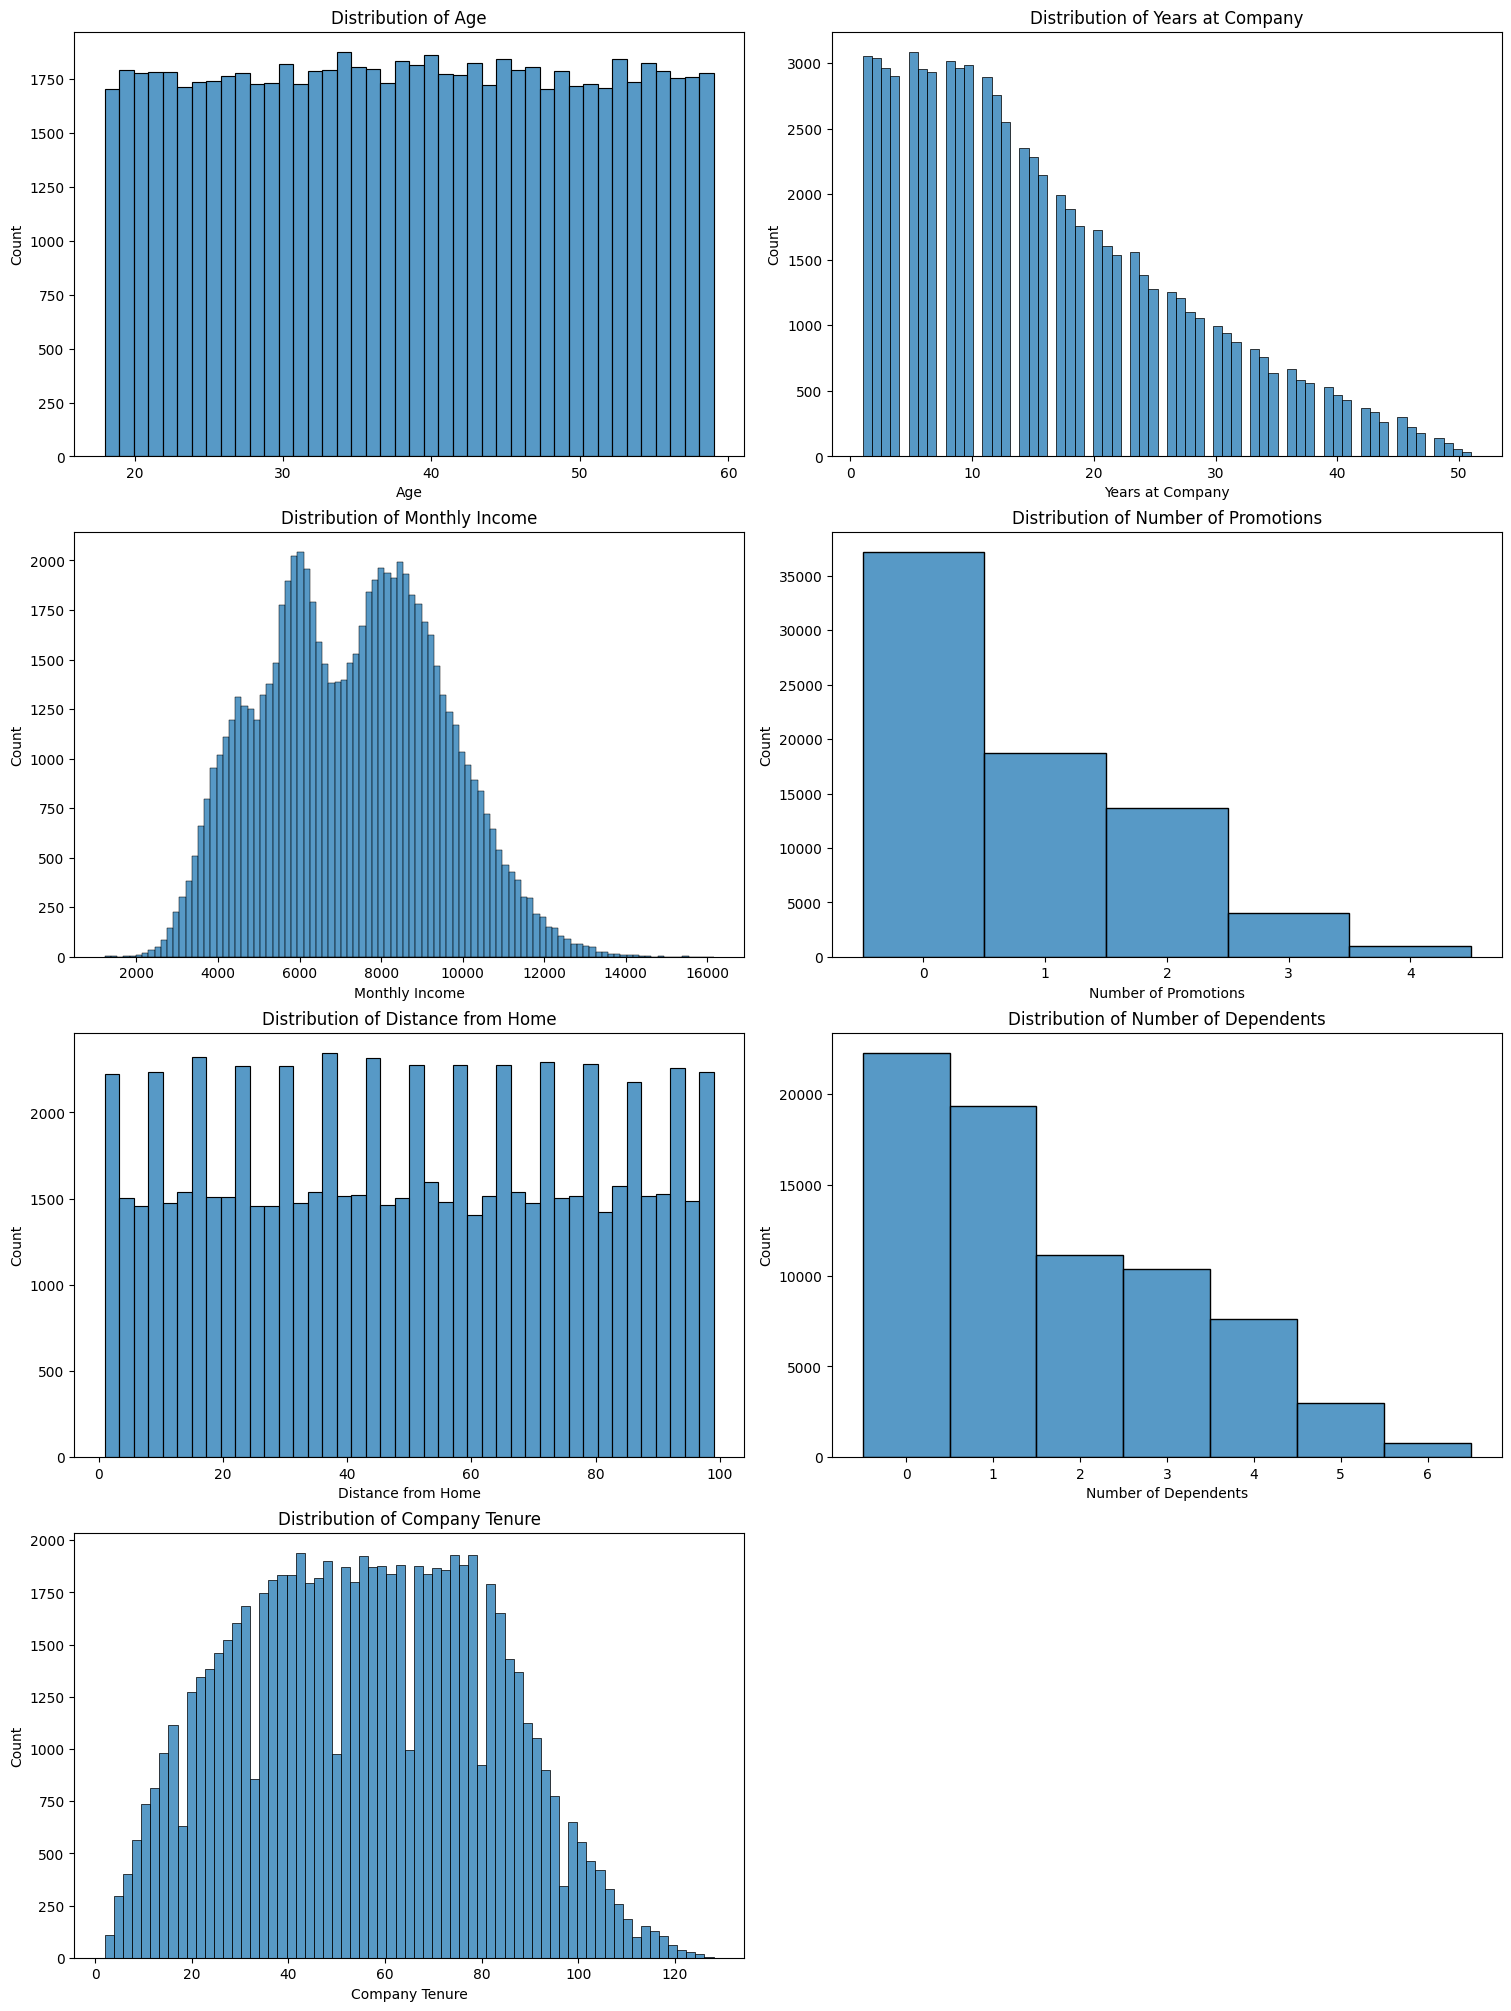

In [8]:
quantitative_vars = ['Age', 'Years at Company', 'Monthly Income', 
                     'Number of Promotions','Distance from Home' ,'Number of Dependents', 'Company Tenure']
num_distribution(data,quantitative_vars)

All distributions are far from normal.

**Category count**

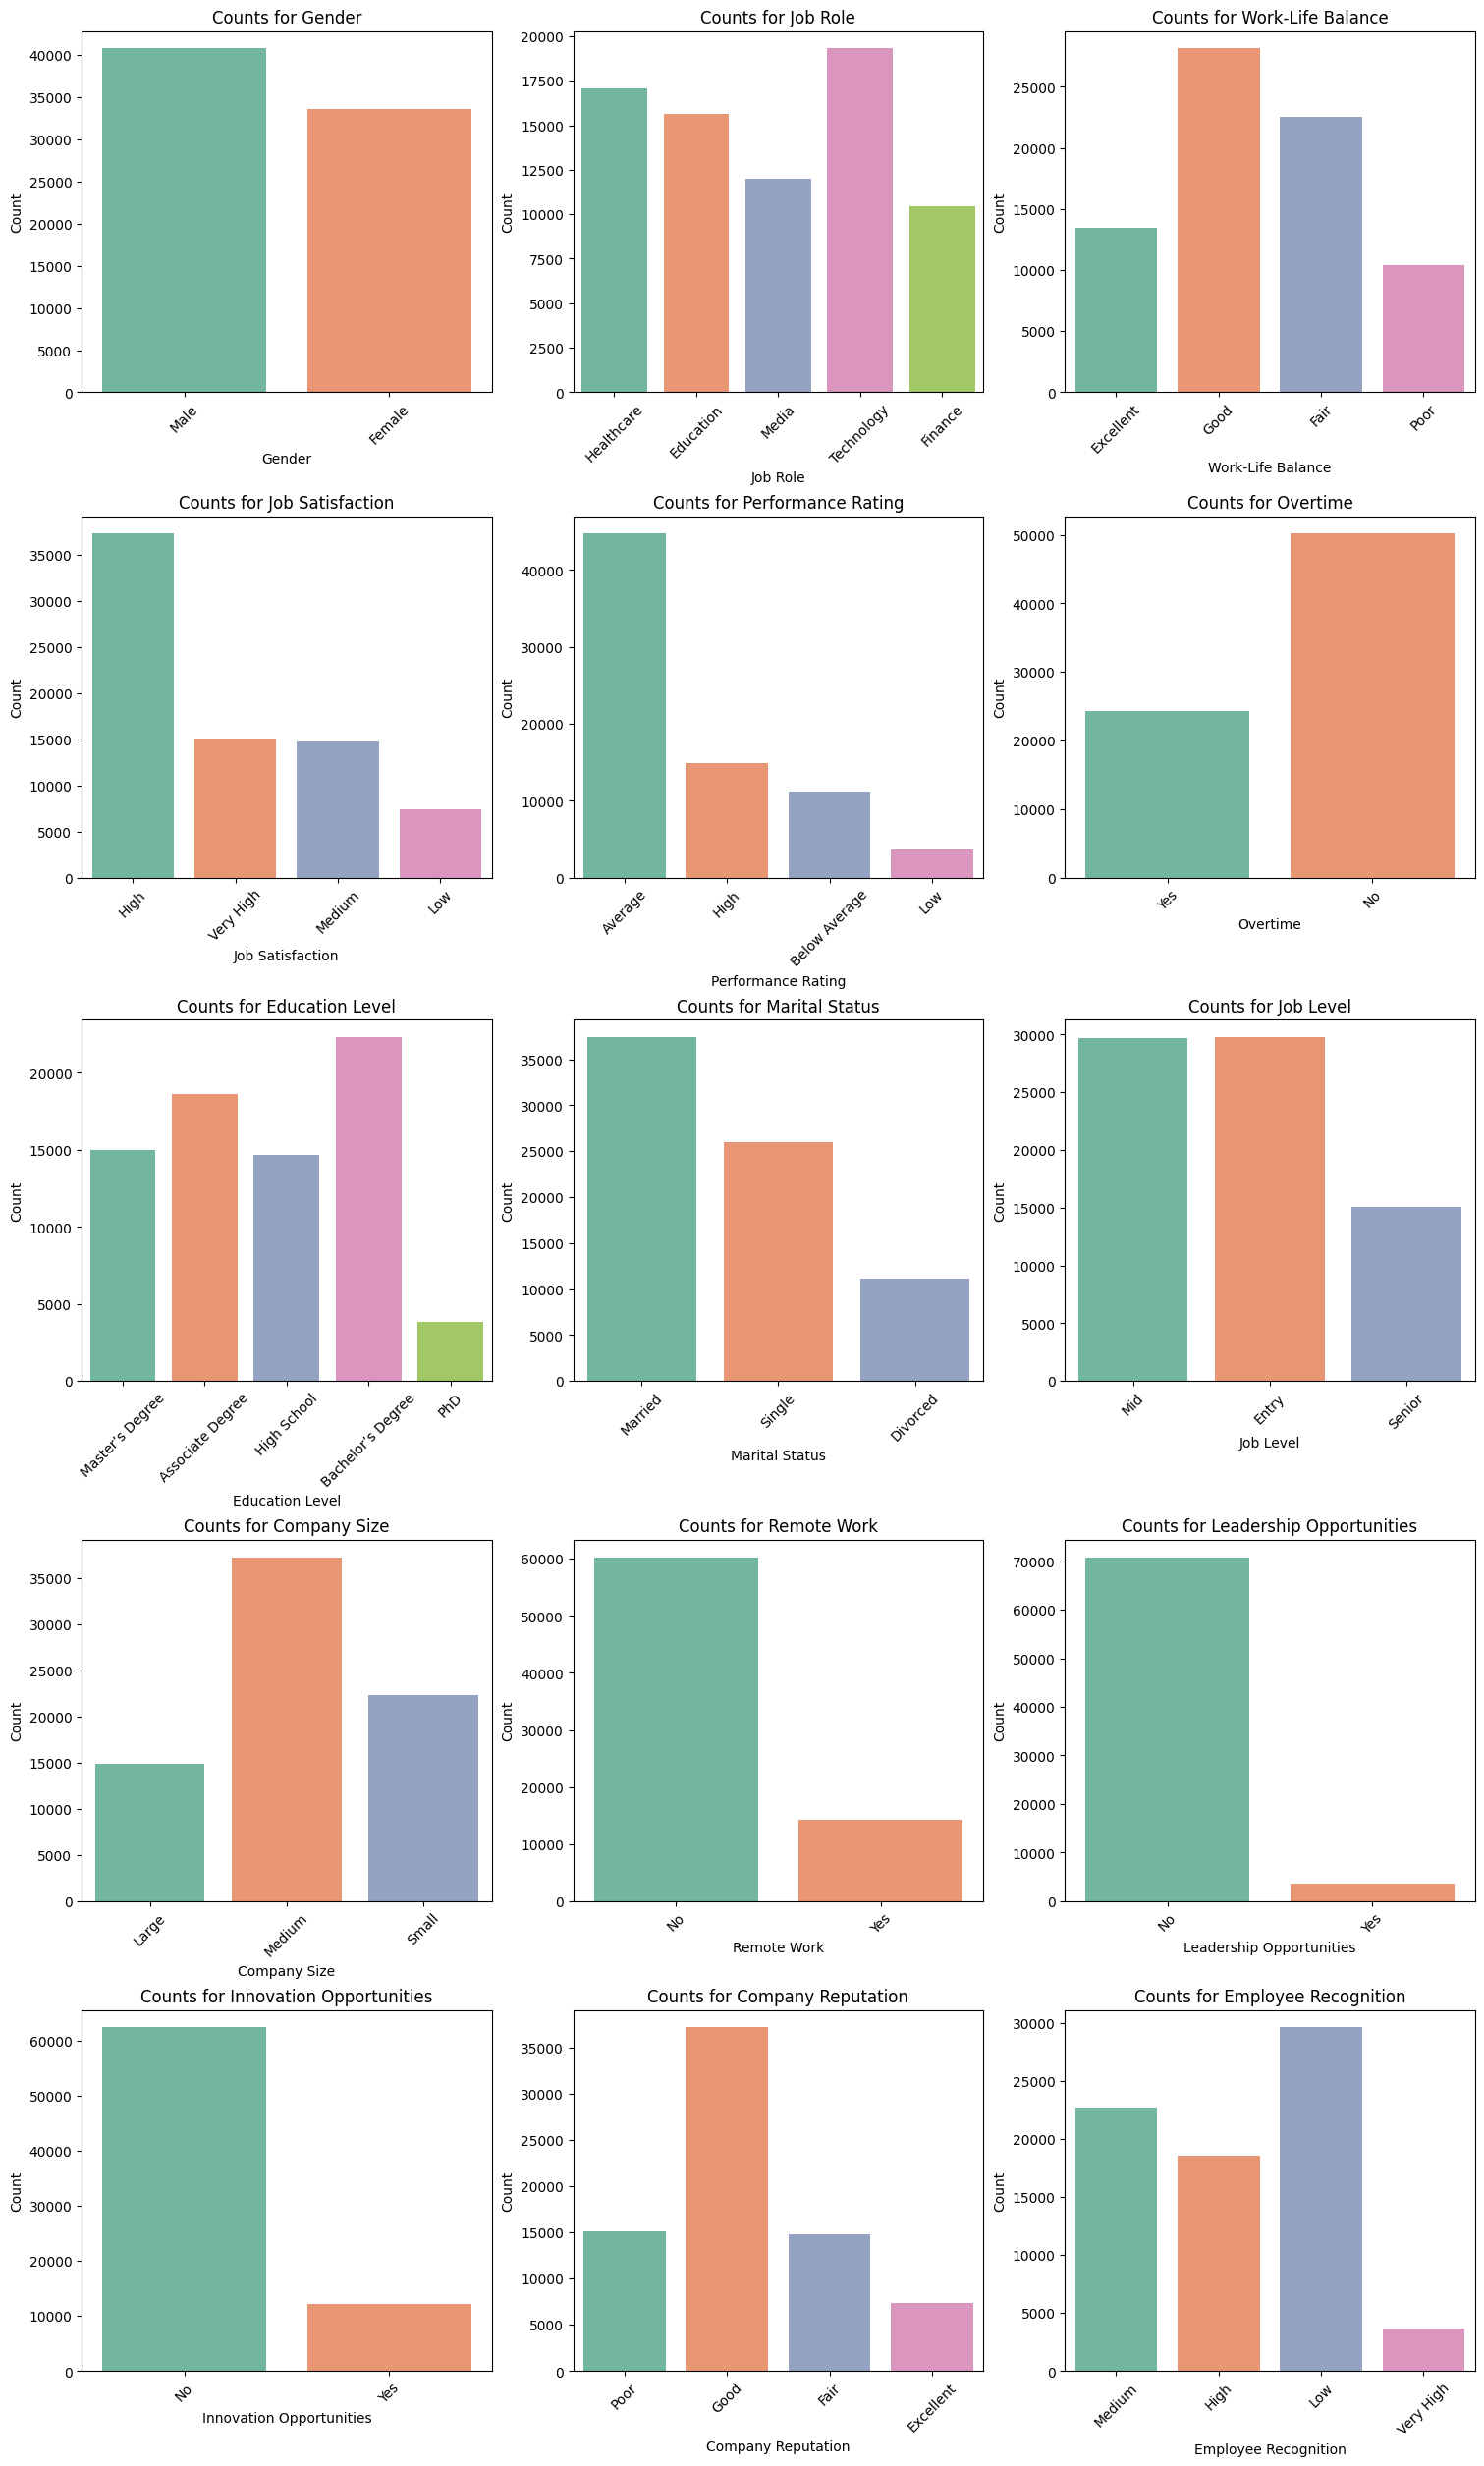

In [9]:
categorical_vars = ['Gender','Job Role','Work-Life Balance','Job Satisfaction', 
                    'Performance Rating','Overtime','Education Level','Marital Status',
                    'Job Level','Company Size','Remote Work','Leadership Opportunities',
                    'Innovation Opportunities', 'Company Reputation','Employee Recognition']
cat_counts(data,categorical_vars)

Usually, there is one dominant class while the others are much smaller, as seen in `Performance Rating.` However, there are exceptions, such as in `Job Role`.

### Outliers

The data will be examined for outliers in a multivariate sense using the Isolation Forest algorithm. Dealing with outliers is important because they can distort statistical analyses, skew model predictions, and lead to inaccurate insights.

`Isolation Forest` is an unsupervised machine learning algorithm for anomaly detection, which isolates outliers by recursively partitioning data points using random splits.

**Distributions after removing outliers**

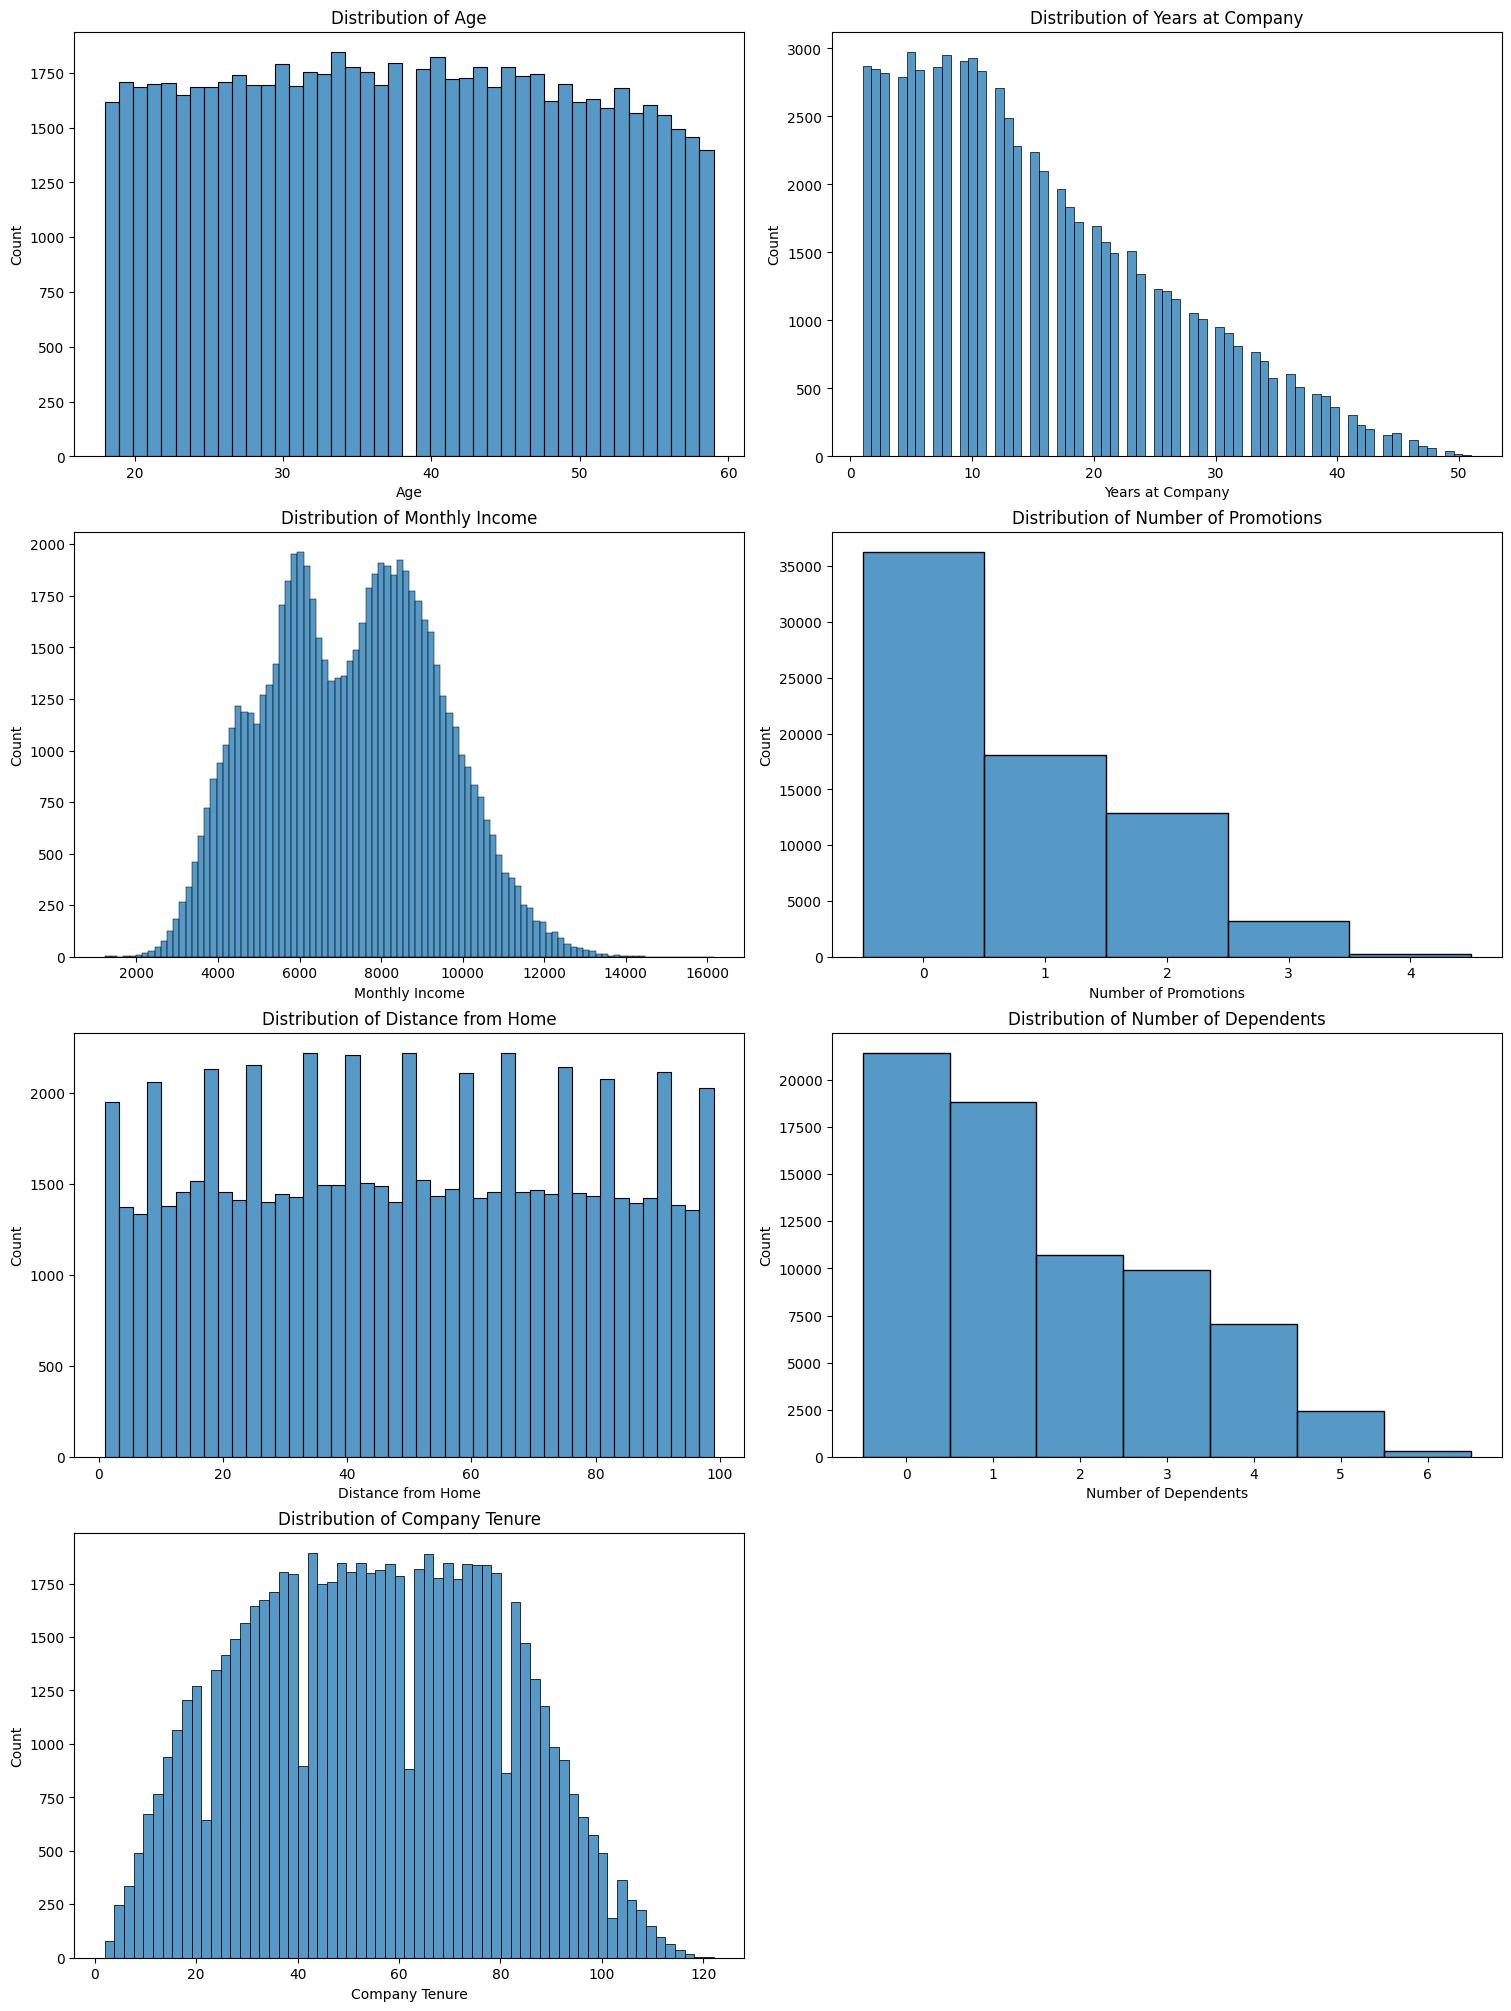

In [10]:
data_cleaned = remove_outliers_from_numerical(data,quantitative_vars,0.05)
num_distribution(data_cleaned,quantitative_vars)

The distributions changed slightly after addressing outliers. This is most noticeable in `Number of Dependents` and `Number of Promotions`, where the smallest counts are significantly reduced.

### Influence on Y variable

The impact of variables X on variable Y was analyzed, and significant variables were identified.

**Numerical**

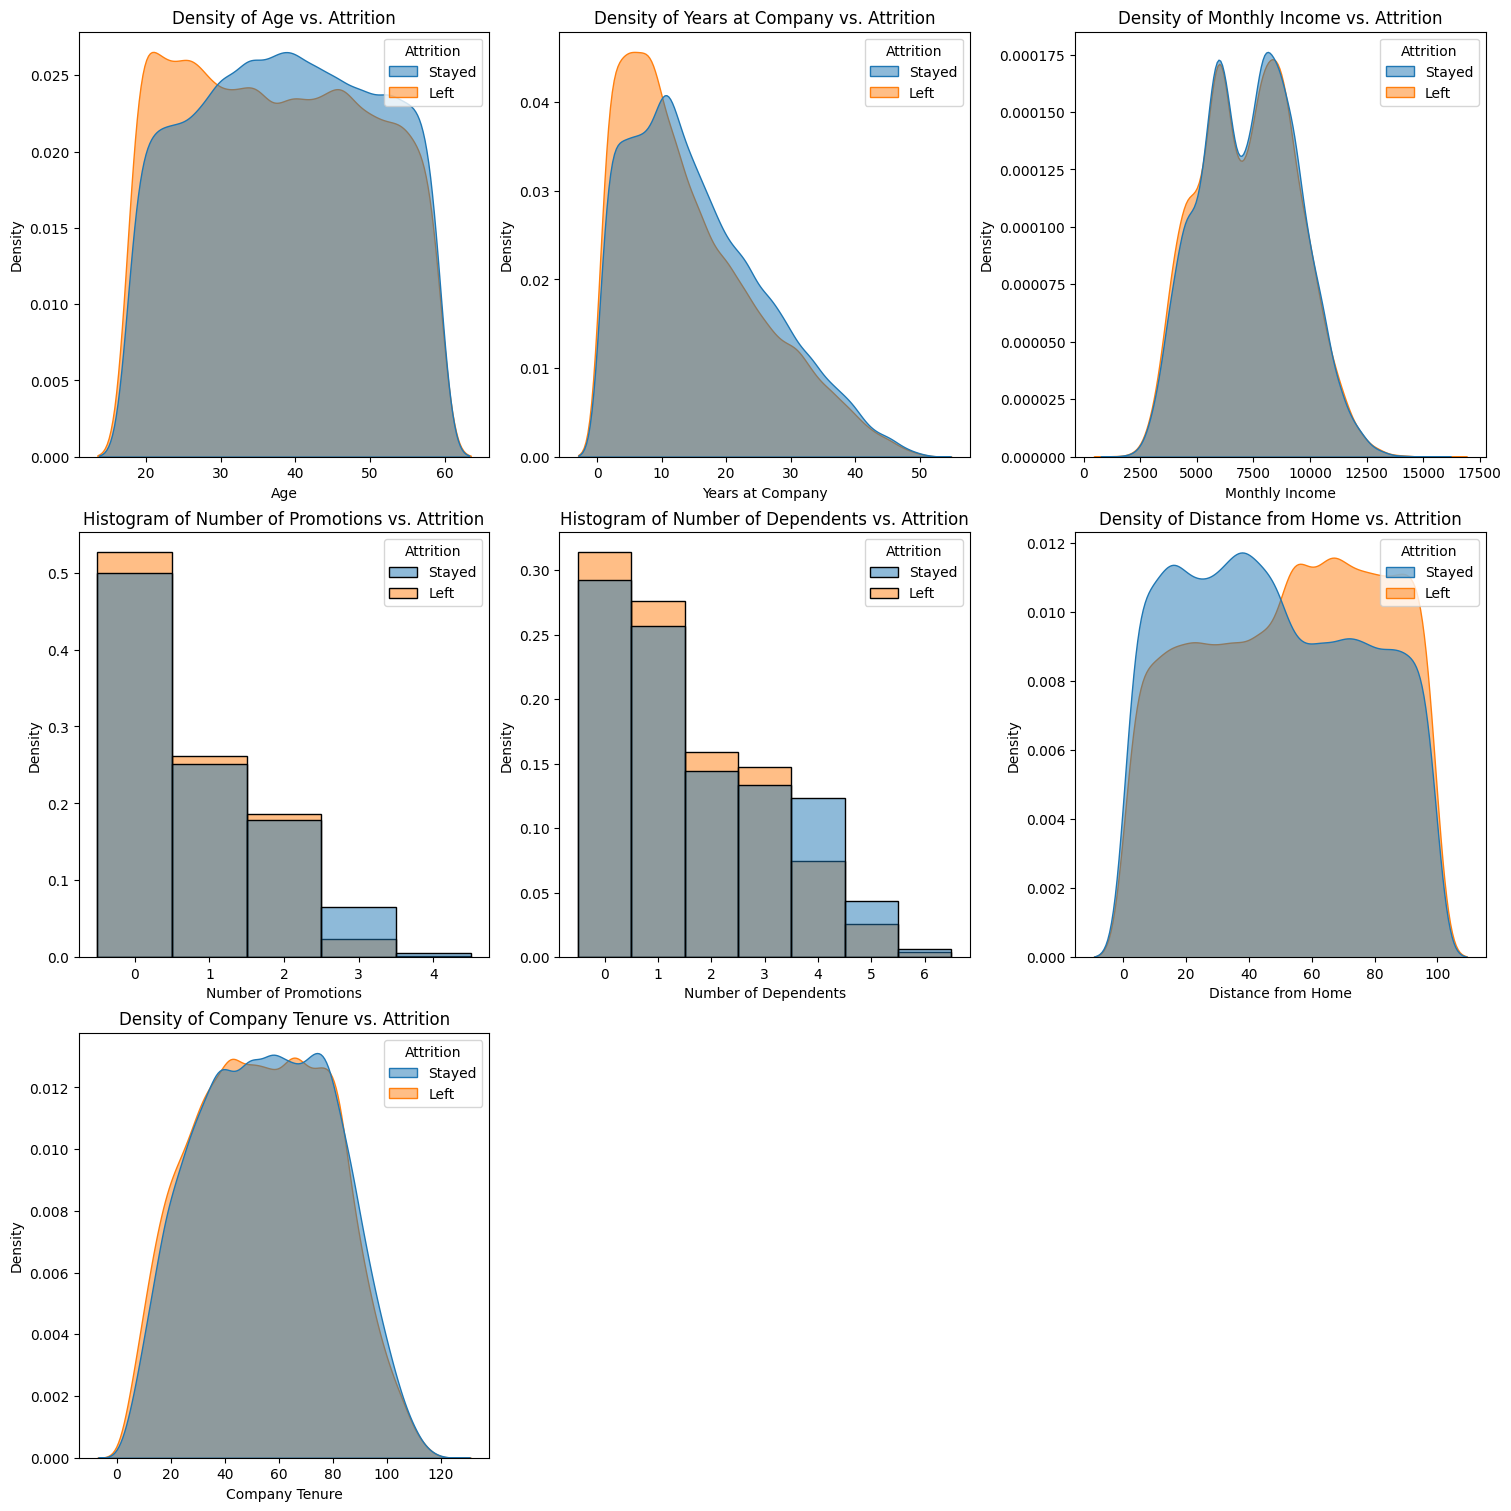

In [11]:
quantitative_vars = ['Age', 'Years at Company', 'Monthly Income', 
                     'Number of Promotions',  'Number of Dependents','Distance from Home', 'Company Tenure']

num_density(data_cleaned,quantitative_vars)

`Monthly Income` and `Company Tenure` do not seem to have an influence on `Attrition`, as their density plots for different categories of Y almost overlap. For these reasons, they will be removed.


**Categorical**

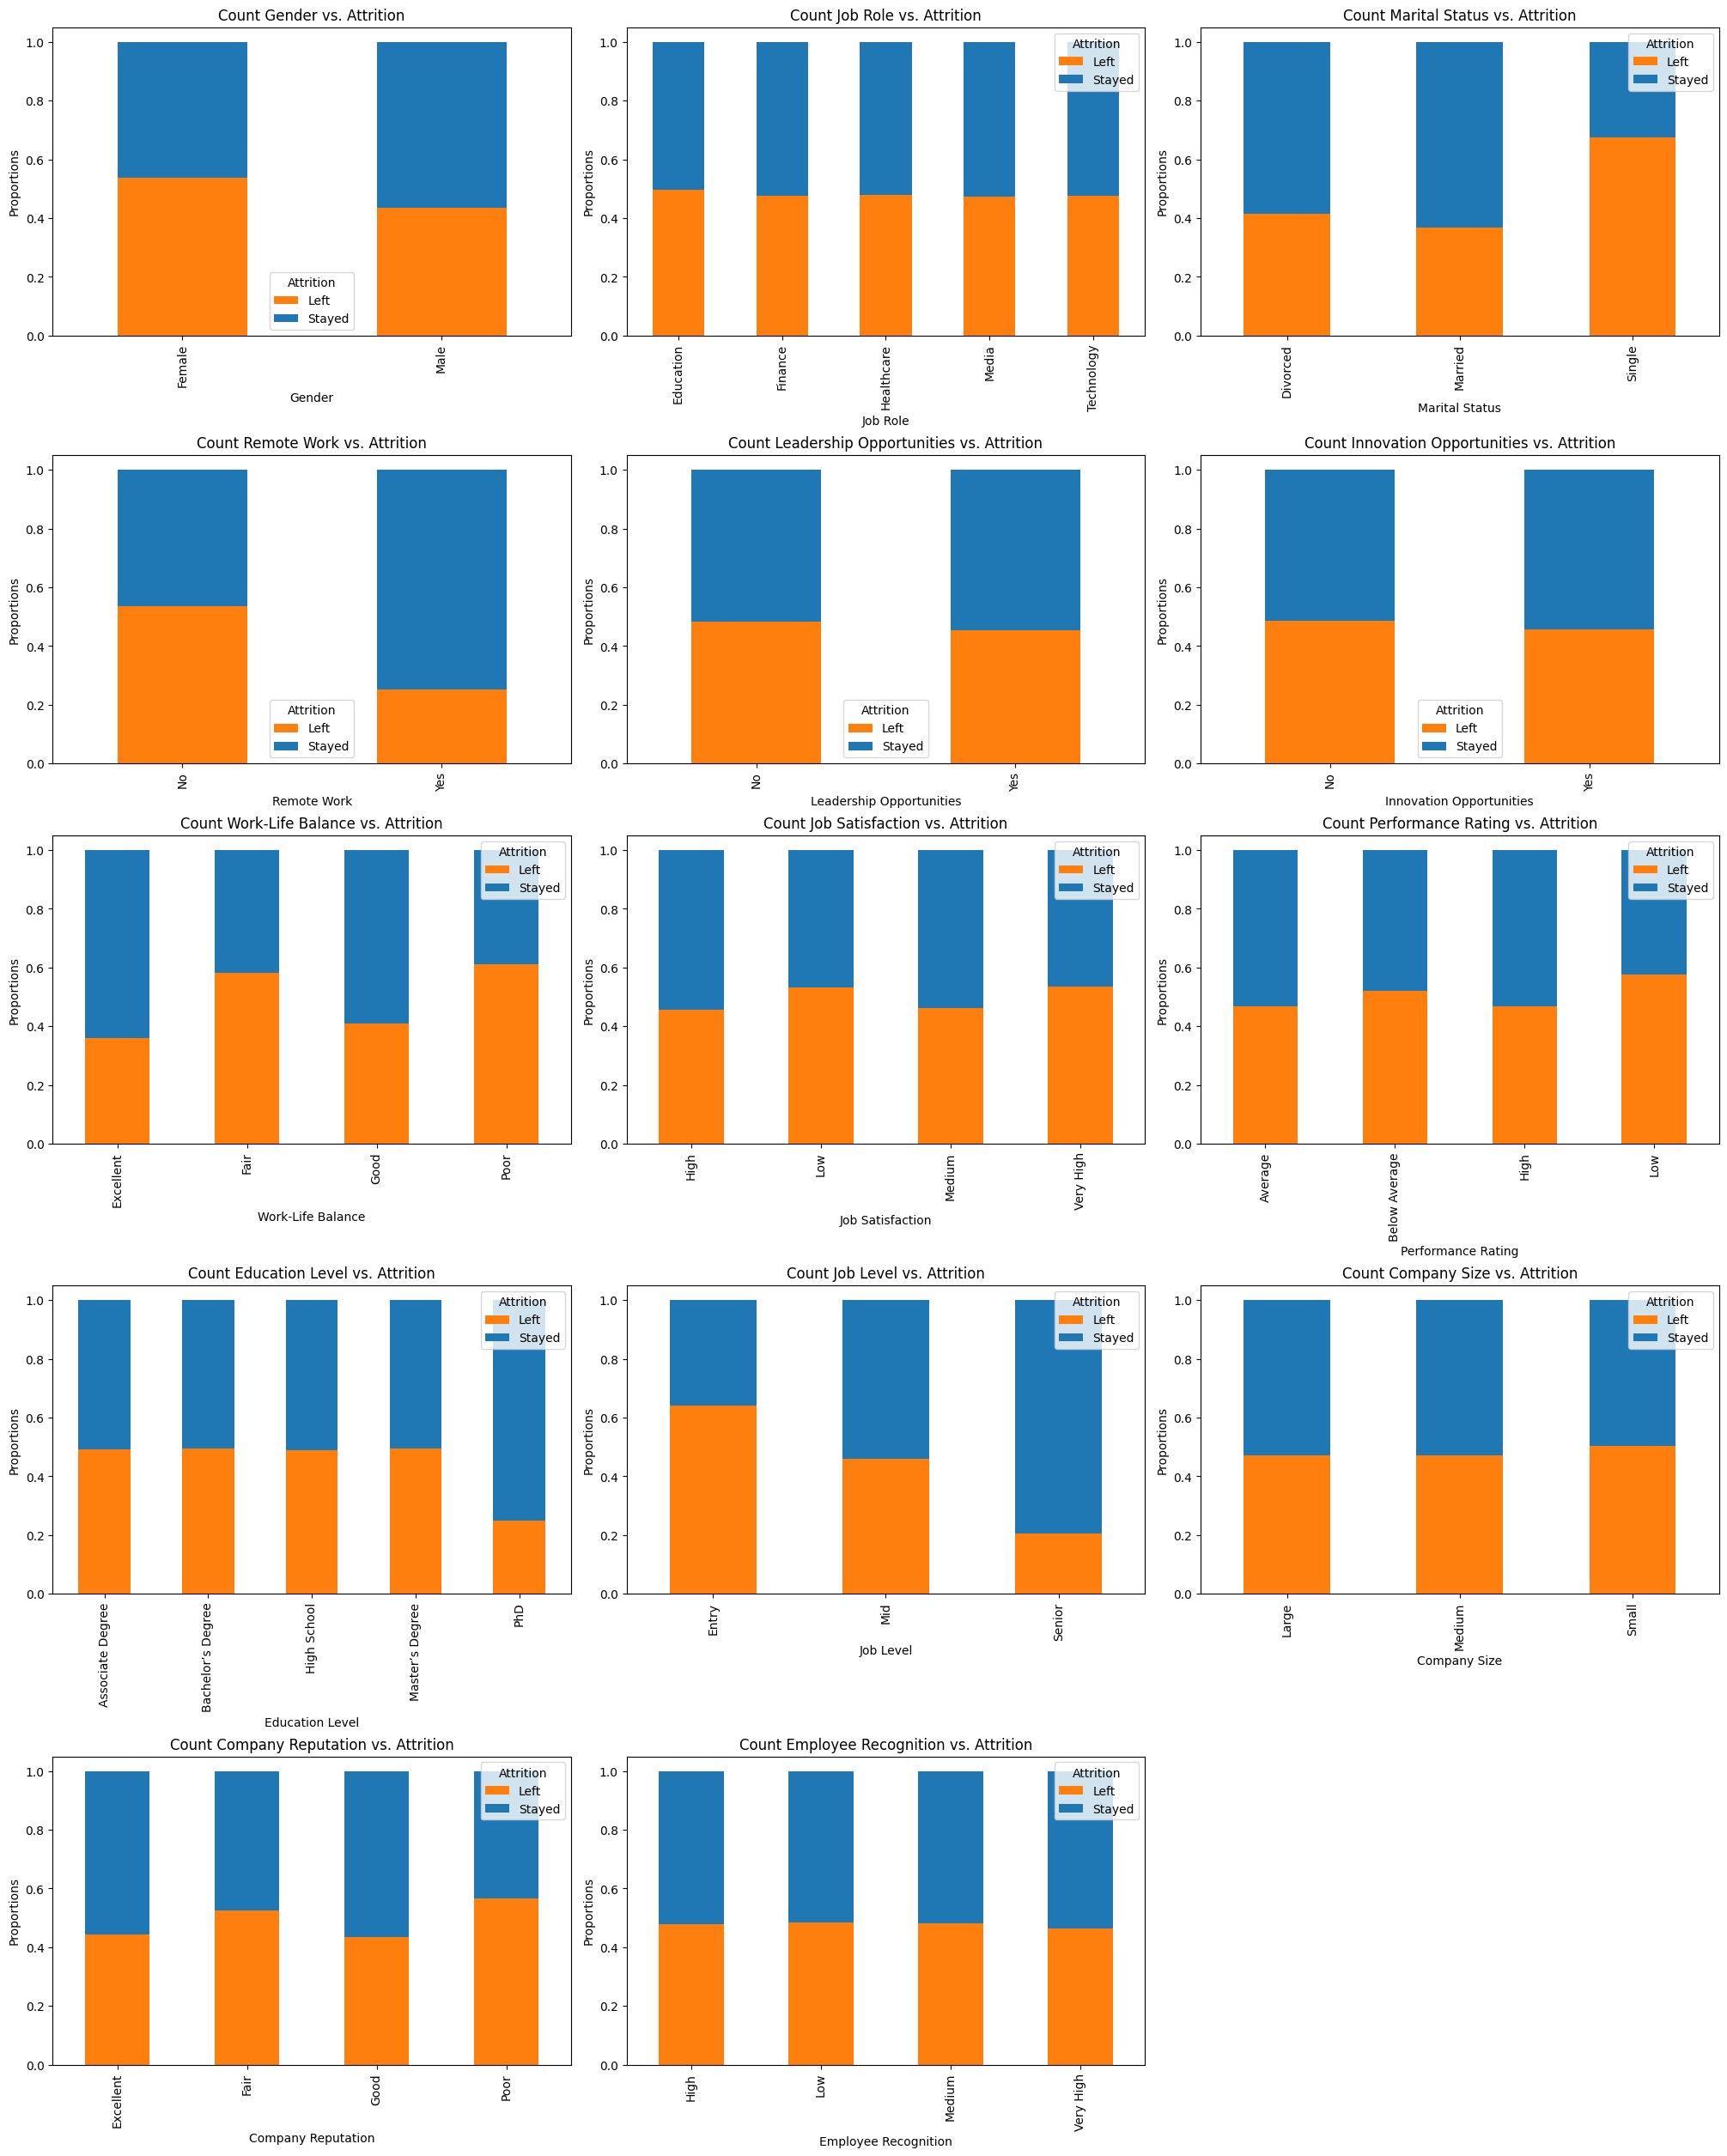

In [12]:

categorical_vars = ['Gender', 'Job Role', 'Marital Status', 'Remote Work', 
                    'Leadership Opportunities', 'Innovation Opportunities', 
                    'Work-Life Balance', 'Job Satisfaction', 'Performance Rating', 
                    'Education Level', 'Job Level', 'Company Size', 
                    'Company Reputation', 'Employee Recognition']

cat_contingency(data_cleaned,categorical_vars)


`Job Role`, `Leadership Opportunities`, `Innovation Opportunities`, `Company Size` and `Employee Recognition` do not seem to have an influence on `Attrition`, as both categories remain within the 0.5 range across all groups in their respective plots.

To reduce complexity of the model:
-`Performance Rating` will be transformed into 2 categories: Positive and Negative
-`Education Level` will be transformed into 2 categories: PhD and Below PhD
-`Company Reputation` will be transformed into 2 categories: High and Low

### Variables - only important

Here is the data after removing non influential variables.

In [13]:
data_cleaned.drop(columns=['Monthly Income', 'Company Tenure', 'Job Role',
                   'Leadership Opportunities', 'Innovation Opportunities', 
                   'Company Size', 'Employee Recognition'], inplace=True)
data_cleaned

,Age,Gender,Years at Company,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,Education Level,Marital Status,Number of Dependents,Job Level,Remote Work,Company Reputation,Attrition
0,36,Male,13,Excellent,High,Average,1,Yes,83,Master’s Degree,Married,1,Mid,No,Poor,Stayed
1,35,Male,7,Good,High,Average,1,Yes,55,Associate Degree,Single,4,Entry,No,Good,Left
2,50,Male,7,Fair,High,Average,3,Yes,14,Associate Degree,Divorced,2,Senior,No,Good,Stayed
3,58,Male,44,Fair,Very High,High,0,Yes,43,Master’s Degree,Single,4,Entry,No,Poor,Left
4,39,Male,24,Good,High,Average,0,Yes,47,Master’s Degree,Married,6,Mid,Yes,Good,Stayed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,50,Female,12,Fair,High,Average,1,Yes,66,Bachelor’s Degree,Single,2,Senior,No,Poor,Left
74494,18,Male,4,Fair,High,High,3,No,42,Associate Degree,Single,0,Senior,No,Fair,Left
74495,22,Female,14,Fair,High,High,0,Yes,34,Master’s Degree,Married,2,Entry,No,Good,Stayed
74496,23,Male,8,Fair,Very High,Average,0,No,62,Bachelor’s Degree,Single,0,Entry,No,Good,Left


### Balance

Balance refers to the proportion of observations in class 1 relative to class 0.

In [14]:
left = int(data_cleaned['Attrition'].eq('Left').sum())
balance = round(left/data_cleaned.shape[0],2)*100
balance

48.0

Data is pretty balanced, so there is no need for under/over sampling. 

## Models

### Preparing data

Ordinal variables  are transformed using an OrdinalEncoder, which assigns numerical values to each category in the predefined order.

In [15]:
encoder = OrdinalEncoder(categories=[
    ["Poor","Fair", "Good", "Excellent"],     
    ["Low", "Medium","High", "Very High"],       
    ["Low", "Below Average","Average", "High"],         
    ["High School","Associate Degree", "Bachelor’s Degree","Master’s Degree", "PhD"],
    ["Entry", "Mid","Senior"],
    ["Poor","Fair", "Good", "Excellent"] 
])

ordinal_col = ["Work-Life Balance","Job Satisfaction","Performance Rating","Education Level","Job Level","Company Reputation"]
data_cleaned[ordinal_col] = encoder.fit_transform(data_cleaned[ordinal_col])

Categorical variables with 2 classes are transformed using the map function, which replaces the original string values with numerical values (1 and 0) for binary attributes.

In [16]:
data_cleaned["Gender"] = data_cleaned["Gender"].map({"Male": 1, "Female": 0})
data_cleaned["Overtime"] = data_cleaned["Overtime"].map({"Yes": 1, "No": 0})
data_cleaned["Remote Work"] = data_cleaned["Remote Work"].map({"Yes": 1, "No": 0})
data_cleaned["Attrition"] = data_cleaned["Attrition"].map({"Left": 1, "Stayed": 0})

Categorical variable "Marital Status" is transformed into dummy variables, with the first category dropped to avoid multicollinearity.

In [17]:
dummies = pd.get_dummies(data_cleaned["Marital Status"], prefix="Marital_Status", drop_first=True,dtype=int)
data_cleaned = data_cleaned.drop("Marital Status", axis=1)
data_cleaned = pd.concat([data_cleaned.iloc[:, :10], dummies, data_cleaned.iloc[:, 10:]], axis=1)

Dataset after changes:

In [18]:
data_cleaned

,Age,Gender,Years at Company,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,Distance from Home,Education Level,Marital_Status_Married,Marital_Status_Single,Number of Dependents,Job Level,Remote Work,Company Reputation,Attrition
0,36,1,13,3.0,2.0,2.0,1,1,83,3.0,1,0,1,1.0,0,0.0,0
1,35,1,7,2.0,2.0,2.0,1,1,55,1.0,0,1,4,0.0,0,2.0,1
2,50,1,7,1.0,2.0,2.0,3,1,14,1.0,0,0,2,2.0,0,2.0,0
3,58,1,44,1.0,3.0,3.0,0,1,43,3.0,0,1,4,0.0,0,0.0,1
4,39,1,24,2.0,2.0,2.0,0,1,47,3.0,1,0,6,1.0,1,2.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74493,50,0,12,1.0,2.0,2.0,1,1,66,2.0,0,1,2,2.0,0,0.0,1
74494,18,1,4,1.0,2.0,3.0,3,0,42,1.0,0,1,0,2.0,0,1.0,1
74495,22,0,14,1.0,2.0,3.0,0,1,34,3.0,1,0,2,0.0,0,2.0,0
74496,23,1,8,1.0,3.0,2.0,0,0,62,2.0,0,1,0,0.0,0,2.0,1


### Data division

The dataset will be split into 80% for training and 20% for testing.

In [19]:
X = data_cleaned.iloc[:, :-1]
y = data_cleaned.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Since the dataset is fairly balanced, a threshold of 0.5 will be used.

### Random Forest

Random Forest is an ensemble machine learning model that combines multiple decision trees to improve accuracy and reduce overfitting. By aggregating the predictions of individual trees, it delivers robust performance for both classification and regression tasks.

Most important hyperparameters:
- `n_estimators`: Number of trees in the forest.
- `max_depth`: Maximum depth of each tree. Controls overfitting by limiting tree growth. 
- `min_samples_split`: Minimum number of samples required to split an internal node.
- `min_samples_leaf`: Minimum number of samples required at a leaf node.
- `max_leaf_nodes`: Maximum number of leaf nodes in a single tree.
- `max_features`: Number of features to consider when finding the best split.

**Base model**

In this project, the base model refers to a single model with parameters chosen by the author.

In [20]:
rf = RandomForestClassifier(n_estimators=100,max_features='sqrt',max_depth=5,max_leaf_nodes=10,min_samples_leaf=100,n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, max_leaf_nodes=10, min_samples_leaf=100,
                       n_jobs=-1)

*Training metrics for base model*

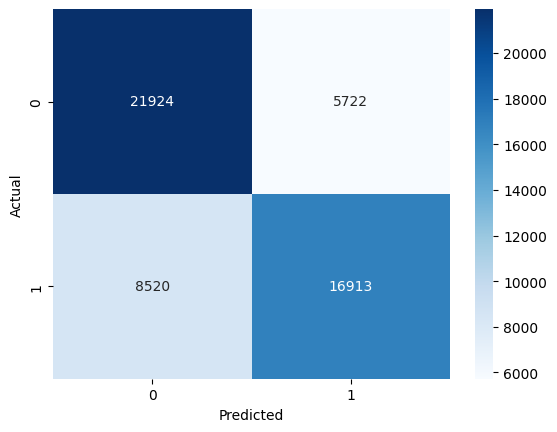

Recall 0.6650021625447253
Specificity: 0.7930261158938002
Accuracy: 0.7316829631304282


In [21]:
y_pred = rf.predict(X_train)
con_mat(y_train,y_pred)
show_metrics(y_train,y_pred)


*Test metrics for base model*

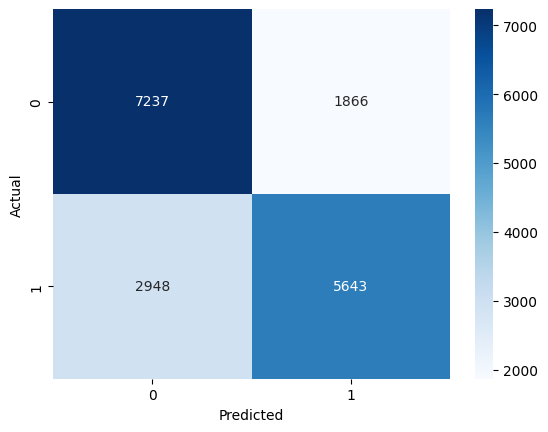

Recall 0.6568501920614597
Specificity: 0.7950126331978469
Accuracy: 0.7279303718774726


In [22]:
y_pred = rf.predict(X_test)
con_mat(y_test,y_pred)
show_metrics(y_test,y_pred)

Results for the training dataset are slightly better, but the differences are not significant. The algorithm favors correctly classifying observations with class 0, as specificity (0.78) is higher than recall (0.65). The overall accuracy is 0.72, indicating that the model is correct in 72% of cases. Recall could be improved, as it is almost 13 percentage points lower than specificity.

*Feature importances*

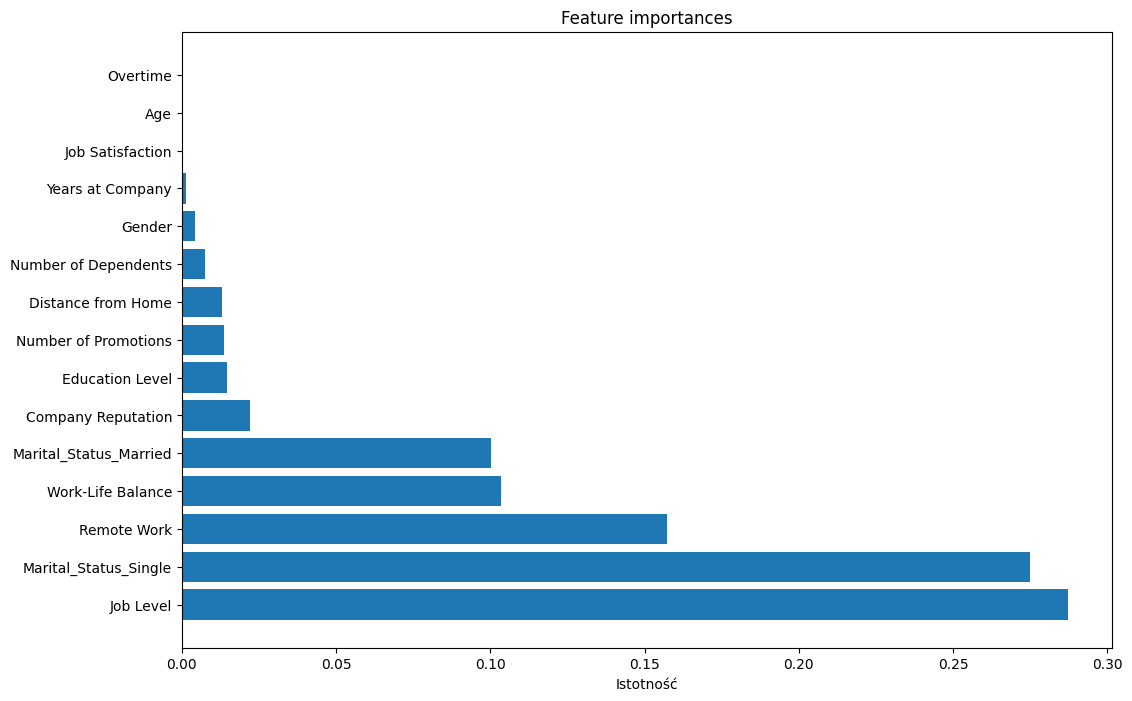

In [23]:
importance(rf,X_train)

**Hyperparameters tuning**

Hyperparameter tuning is the process of selecting the optimal set of hyperparameters for a machine learning model to improve its performance and generalization on unseen data. 
In this case, the author used GridSearch with 5-fold cross-validation, which is a technique for systematically searching through a specified hyperparameter space by training and evaluating a model for every possible combination of hyperparameters. GridSearch helps identify the best hyperparameters by evaluating the model's performance using cross-validation.

When using GridSearch, the scoring is based on a function defined at the beginning of the project. This function takes accuracy, specificity, and recall, with assigned weights (1, 0.5, 0.5), and produces a score that is the sum of these metrics. This approach ensures that all three metrics are considered, with overall accuracy being the most important to avoid situations where one metric is significantly lower than the others.

In [24]:
rf = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100,200],  
    'max_depth': [None, 3, 5, 10],   
    'min_samples_split': [500, 1000, 5000],   
    'min_samples_leaf': [250, 500, 2500],     
    'max_features': ['sqrt', 'log2'] 
}

custom_scorer = make_scorer(custom_score)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, verbose=1, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)
print("Best metrics:", grid_search.best_score_)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 250, 'min_samples_split': 500, 'n_estimators': 100}
Best metrics: 0.7439598427168731


After 216 combinations + 5-fold cross validation, the best hyperparameters are listed above, with a scoring value of 0.74.

*Training metrics for best model*

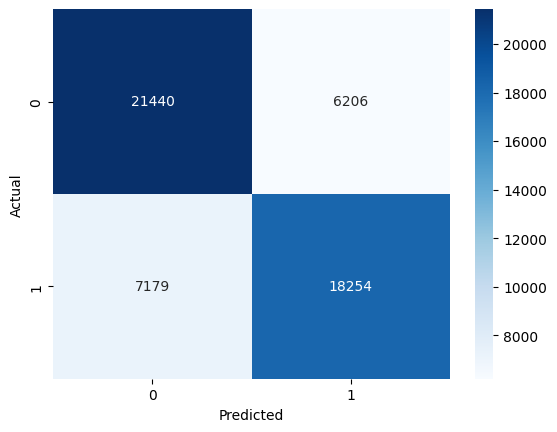

Recall 0.7177289348484253
Specificity: 0.7755190624321783
Accuracy: 0.7478287081519999


In [25]:
y_pred = best_model.predict(X_train)
con_mat(y_train,y_pred)
show_metrics(y_train,y_pred)

*Test metrics for best model*

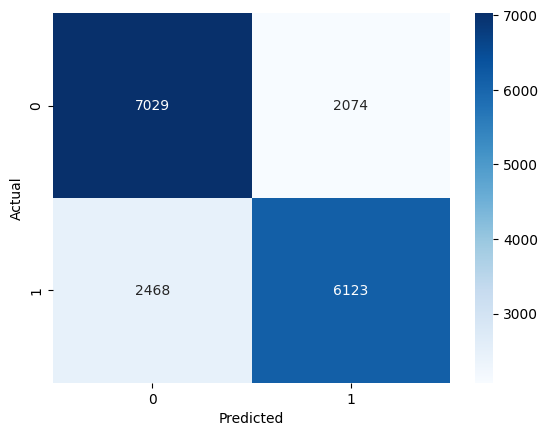

Recall 0.7127226166918869
Specificity: 0.7721630231791717
Accuracy: 0.7433028145133944


In [26]:
y_pred = best_model.predict(X_test)
con_mat(y_test,y_pred)
rf_accuracy,rf_specificity,rf_recall = show_metrics(y_test,y_pred,True)

The same observation applies as with the base model: there are only slight differences between the results for the training and test datasets. Despite the initial dataset being fairly balanced, both models tend to predict observations as class 0 (both correctly and incorrectly) more frequently. Compared to the base model, all metrics have improved, indicating that GridSearch helped in finding a better solution. Now, the model predicts correctly in 74% of cases, with 71% of class 1 correctly classified as 1 and 77% of class 0 correctly classified as 0.

*Feature importances*

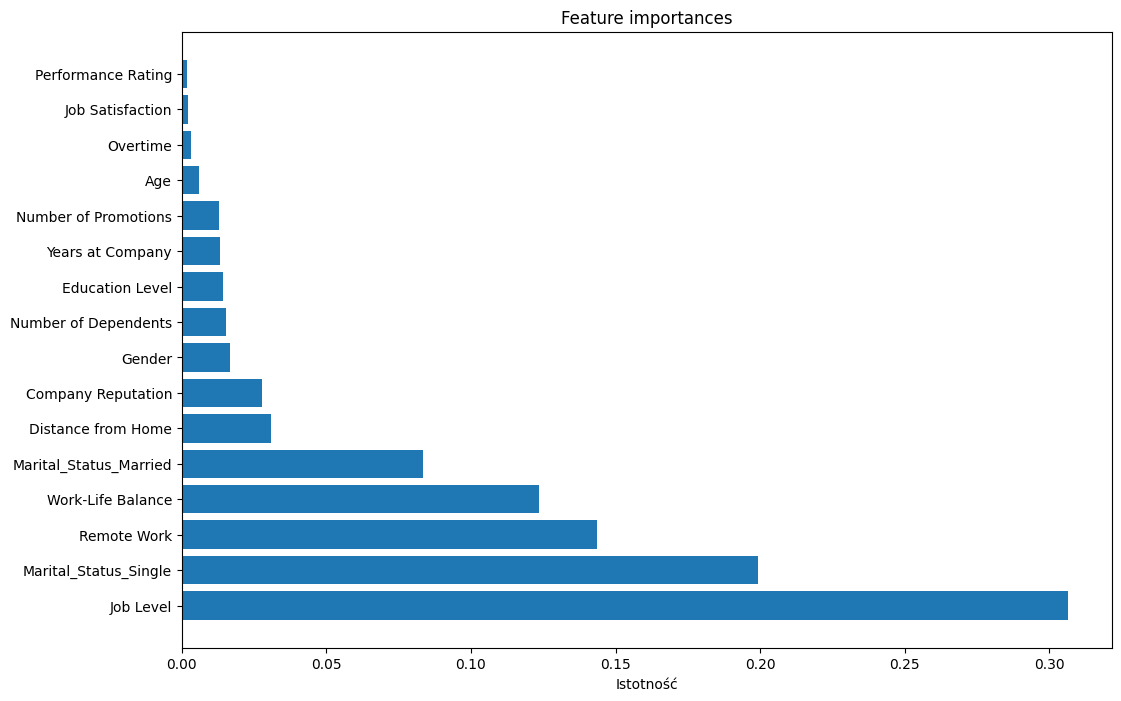

In [27]:
importance(best_model,X_train)

**ROC Curve**

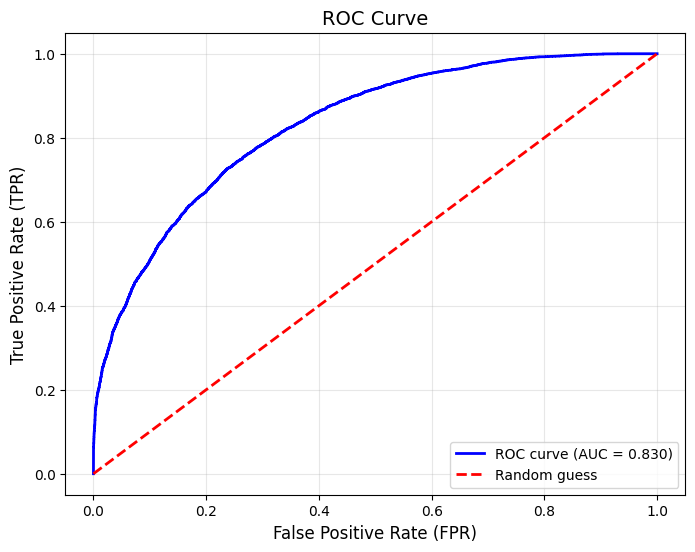

In [28]:
y_proba = best_model.predict_proba(X_test)[:, 1]  
roc_plot(y_test,y_proba)

An AUC of 0.83 means that the model has an 83% probability of correctly distinguishing between a randomly chosen positive instance and a randomly chosen negative instance.

### Logistic Regression


Logistic Regression is a statistical model used for binary classification tasks, where the output is a probability that can be mapped to a binary outcome (0 or 1). It models the relationship between input features and the probability of a target class using a logistic function.

Most important hyperparameters (statsmodel Logit):

- `method`: The optimization method to use for fitting the model.
- `maxiter`: The maximum number of iterations to run during optimization.
- `tol`: Tolerance for convergence. 


**Equation**

$log(p/(1-p)) = β₀ + β₁ * Age + β₂ * Gender + β₃ * Years At Company + β₄ * WorkLifeBalance + β₅ * JobSatisfaction + β₆ * PerformanceRating + β₇ * NumberOfPromotions + β₈ * Overtime + β₉ * DistanceFromHome + β₁₀ * EducationLevel + β₁₁ * MaritalStatusMarried + β₁₂ * MaritalStatusSingle + β₁₃ * NumberOfDependents + β₁₄ * JobLevel + β₁₅ * RemoteWork + β₁₆ * CompanyReputation$


**Modifying data**

Numerical data and ordinal variables will be scaled using standardization, as the subsequent models require it. The distances between categories in ordinal variables are not easy to establish, which is why the author decided to standardize only ordinal variables with 4 or more categories, as they might influence the model too much.

In [29]:
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

columns_to_scale = ["Age","Years at Company","Distance from Home","Number of Dependents","Number of Promotions","Education Level"]
scaler = StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
X_test[columns_to_scale] = scaler.fit_transform(X_test[columns_to_scale])

**Correlation matrix**

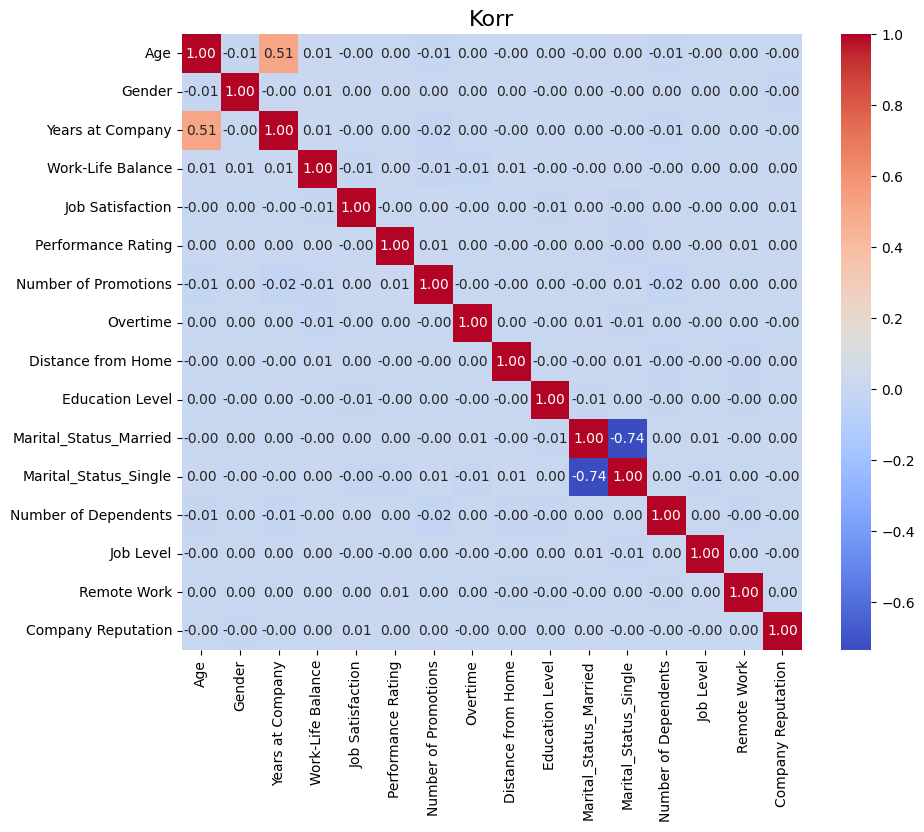

In [30]:
corr_plot(data_cleaned)

Most of the X variables are not correlated with each other. However, `Years at Company` and `Age` show a moderate correlation, which is understandable, as both values tend to increase over time if an employee stays with the company. The two dummy variables derived from `Marital Status` also show correlation, but this is expected since they are both derived from the same original variable.

**Training**

In [31]:
log_reg = sm.Logit(y_train,X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.503411
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              Attrition   No. Observations:                53079
Model:                          Logit   Df Residuals:                    53062
Method:                           MLE   Df Model:                           16
Date:                Tue, 14 Jan 2025   Pseudo R-squ.:                  0.2728
Time:                        21:37:57   Log-Likelihood:                -26721.
converged:                       True   LL-Null:                       -36745.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      2.6915      0.057     47.478      0.000       2.580      

Results show that all variables are important, as all p-values (P>|z|) are below 0.05. Additionally, the table displays the variables along with their respective coefficients.

Interpretation of chosen coefficients:

- The coefficient for Remote Work is -1.7306. This means that, all else being equal, employees who work remotely are less likely to leave the company compared to those who do not work remotely. The odds of an employee leaving are reduced by a factor of exp(-1.7306) ≈ 0.176 for remote workers. In other words, employees who work remotely have about 82.4% lower odds of leaving the company compared to those who do not work remotely.

- The coefficient for Overtime is 0.3522. This indicates that, all else being equal, employees who work overtime are more likely to leave the company compared to those who do not work overtime. The odds of attrition are increased by a factor of exp(0.3522) ≈ 1.423 for employees who work overtime. In other words, employees who work overtime have about 42.3% higher odds of leaving the company compared to those who do not work overtime.

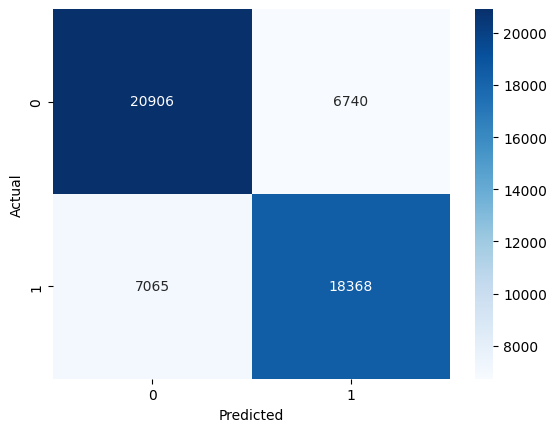

Recall 0.7222113002791649
Specificity: 0.7562034290674962
Accuracy: 0.7399159743024548


In [32]:
y_proba = log_reg.predict(X_train)
y_pred = (y_proba >= 0.5).astype(int) 
con_mat(y_train,y_pred)
show_metrics(y_train,y_pred)

**Test**

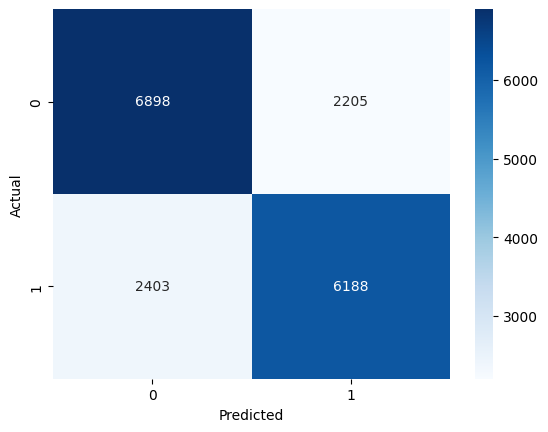

Recall 0.7202886741939238
Specificity: 0.7577721630231792
Accuracy: 0.7395727365208545


In [33]:
y_proba = log_reg.predict(X_test)
y_pred = (y_proba >= 0.5).astype(int)  
con_mat(y_test,y_pred)
l_accuracy,l_specificity,l_recall = show_metrics(y_test,y_pred,True)

There are no significant changes in metrics between the training and test datasets. As in the previous model, observations with class 0 are more a bit more likely to be recognized by the model, but overall, all metrics show similar values. Both False Positives and False Negatives show similar values, which indicates that the model should not be biased towards one direction.

**ROC Curve**

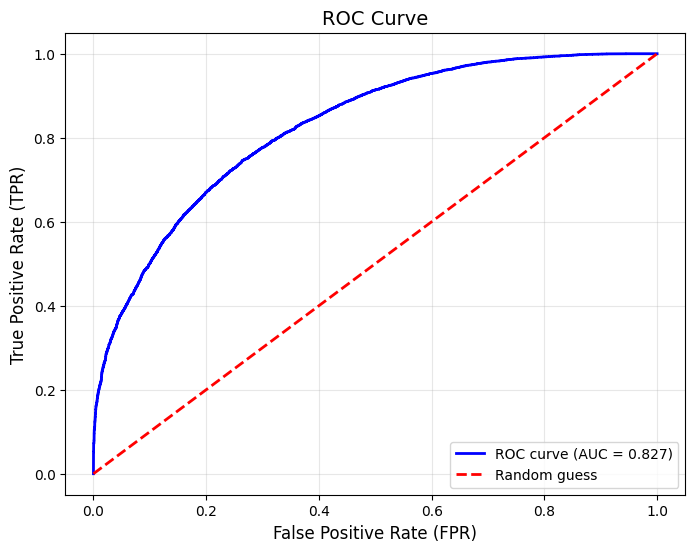

In [34]:
roc_plot(y_test, y_proba)

An AUC of 0.827 means that the model has an 82.7% probability of correctly distinguishing between a randomly chosen positive instance and a randomly chosen negative instance.

### SVM

Support Vector Machine (SVM) is a supervised machine learning model commonly used for classification tasks, but it can also be used for regression. SVM works by finding the hyperplane that best separates the classes in a higher-dimensional space.

- `C`: Regularization parameter. It controls the trade-off between maximizing the margin and minimizing classification errors. 
- `kernel`: Specifies the kernel type to use. 
- `degree`: Degree of the polynomial kernel function ('poly'). It is ignored when the kernel is not polynomial.
- `gamma`: Kernel coefficient for 'rbf', 'poly', and 'sigmoid' kernels. It controls how much influence a single training example has. Low values make the influence of each point more spread out, while high values make the influence more localized.
- `coef0`: Independent term in the kernel function. It is used only for the 'poly' and 'sigmoid' kernels. It helps control the flexibility of the decision boundary.
- `tol`: Tolerance for stopping criterion. If the change in the optimization objective is smaller than this value, the optimization will stop.

In this case, I will use the 'poly' kernel. This means that the algorithm will use a polynomial function to map the input data, allowing it to better separate data points that are not linearly separable in the original feature space.

**Base model**

In [35]:
X_test = X_test.drop('const',axis=1)
X_train = X_train.drop('const',axis=1)

svm = SVC(kernel="poly",gamma="auto",C=1.0,probability=True)
svm.fit(X_train,y_train)

SVC(gamma='auto', kernel='poly', probability=True)

*Train metrics for base model*

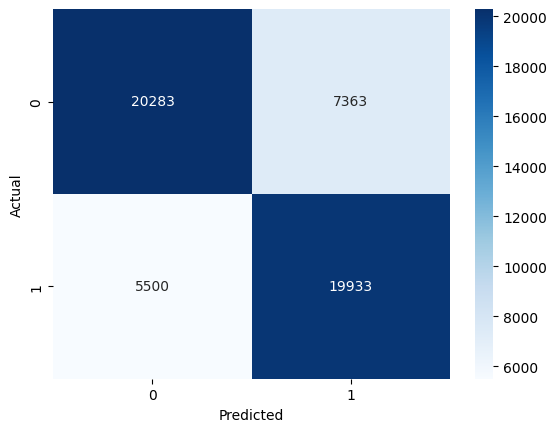

Recall 0.783745527464318
Specificity: 0.7336685234753672
Accuracy: 0.7576631059364344


In [36]:
y_proba = svm.predict_proba(X_train)[:, 1]
y_pred = (y_proba > 0.5).astype(int)
con_mat(y_train,y_pred)
show_metrics(y_train,y_pred)

*Test metrics for base model*

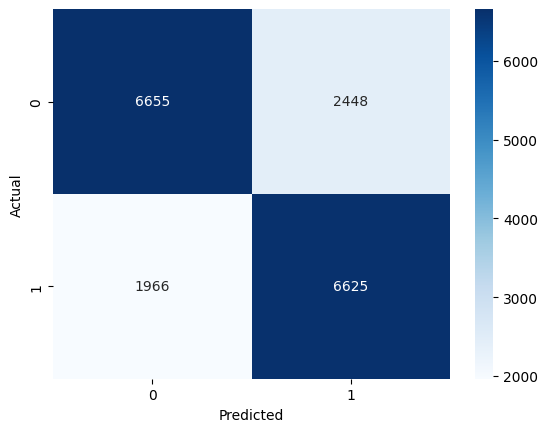

Recall 0.771155860784542
Specificity: 0.7310776667032847
Accuracy: 0.7505369051655929


In [37]:
y_proba = svm.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)
con_mat(y_test,y_pred)
show_metrics(y_test,y_pred)

**Hyperparameters tuning**

The same rules apply to this GridSearch as in the previous one. Fewer combinations and 3-fold cross-validation instead of 5-fold are due to the high computational complexity.

In [38]:
svm = SVC(kernel="poly")

param_grid = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

custom_scorer = make_scorer(custom_score)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, verbose=1, scoring=custom_scorer, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)
print("Best metrics:", grid_search.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best Hyperparameters: {'C': 0.1, 'degree': 3, 'gamma': 0.1}
Best metrics: 0.7489001207522868


After 36 combinations + 3-fold cross validation, the best hyperparameters are listed above, with a scoring value of 0.75.

In [39]:
final_model = SVC(kernel="poly", probability=True, **grid_search.best_params_)
final_model.fit(X_train, y_train)

SVC(C=0.1, gamma=0.1, kernel='poly', probability=True)

*Training metrics for best model*

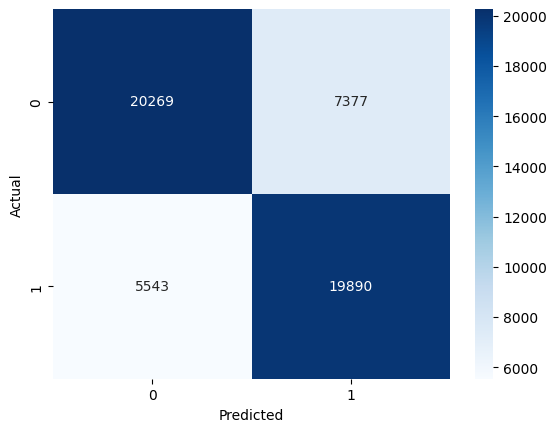

Recall 0.782054810679039
Specificity: 0.7331621211025103
Accuracy: 0.7565892349139961


In [40]:
y_proba = final_model.predict_proba(X_train)[:, 1]
y_pred = (y_proba > 0.5).astype(int)
con_mat(y_train,y_pred)
show_metrics(y_train,y_pred)

*Test metrics for best model*

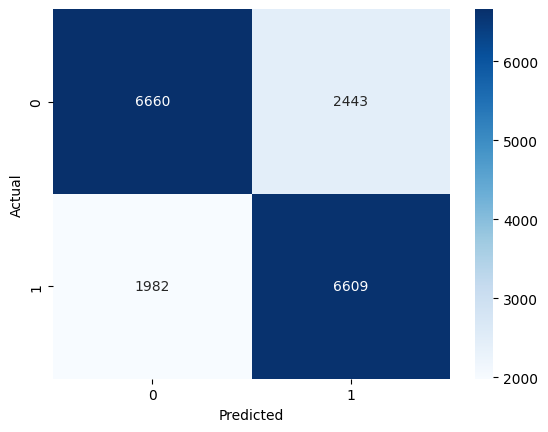

Recall 0.7692934466301944
Specificity: 0.7316269361748874
Accuracy: 0.7499152255001695


In [41]:
y_proba = final_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.5).astype(int)
con_mat(y_test,y_pred)
s_accuracy,s_specificity,s_recall = show_metrics(y_test,y_pred, True)

**ROC Cruve**

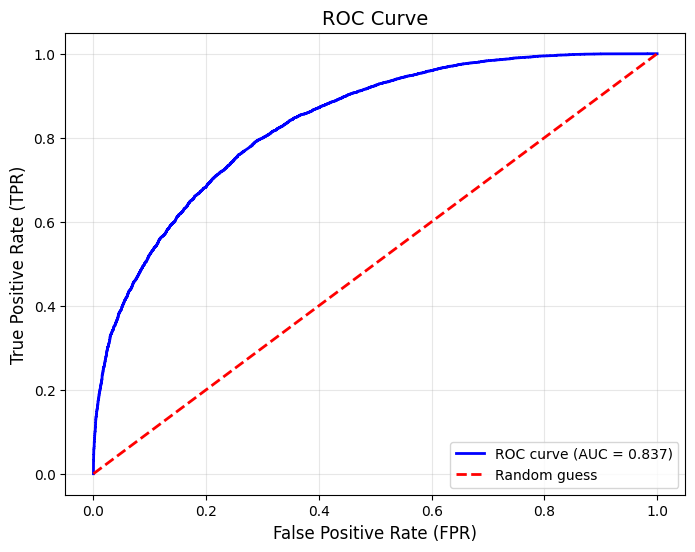

In [42]:
roc_plot(y_test,y_proba)

An AUC of 0.838 means that the model has an 83.8% probability of correctly distinguishing between a randomly chosen positive instance and a randomly chosen negative instance.